# Neural Responses to Familiar and Unfamiliar Stimuli: Building a Binary Classifier

In this experiment, 800 data samples were conducted to record the firing activity from multiple neurons in response to various stimuli. 
This notebook develops a binary classifier that determines, based on the neural firing patterns, whether a given stimulus was familiar or unfamiliar to the neurons. 

- The x-data represent Spike Trains from Multiple Neurons (samples, neurons, timesteps) = firing activity (spikes) of neurons over time
- The y-data consist of output labels that correspond to the level of familiarity (0 for unfamiliar, 1 for familiar), serving as the target variable for classification.

## Step 1: Exploring the Dataset Structure
In a first step, I take a closer look into the data files and their structure. To do this, the packages needed are imported and basic information about the spike train recordings (x_data) and their corresponding familarity labels (y_data) are printed out:

In [25]:
import numpy as np
import matplotlib.pyplot as plt

""" A few helpful settings: """
np.random.seed(42) # ensures reproducibility among random numbers
np.set_printoptions(suppress=True) # printing small floating-point numbers in scientific notation (e^...)


In [26]:
x_data = np.load('x.npy')
y_data = np.load('y.npy')


""" 
Printing the dimension of each file for a better understanding: 
"""

print("Shape of x_data:", x_data.shape) # 3D array with 800 samples, each with 1000 neurons(lines) x 501 timesteps 
print("Shape of y_data:", y_data.shape) # 1D array with 800 values (input familiarity

print("\nFirst dataset in x_data:\n", x_data[0])  # Shows values of the first dataset from x_data
print("First 10 values of y_data:\n", y_data[:10]) # shows the first 10 values from y_data



Shape of x_data: (800, 1000, 501)
Shape of y_data: (800,)

First dataset in x_data:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
First 10 values of y_data:
 [0 1 0 1 0 1 0 1 0 1]


Counting how many stimuli were familiar ($y_{data} == 1$):

In [27]:
not_firing = np.count_nonzero(y_data == 1)
print(not_firing)

400


## Step 2: Visualizing Raw Spike Trains

To get a better idea of the neuronal behavior, spike trains from multiple neurons are randomly selected and visualized across 5 different samples. This helps to observe the firing patterns over time and analyze the activity of the neurons.

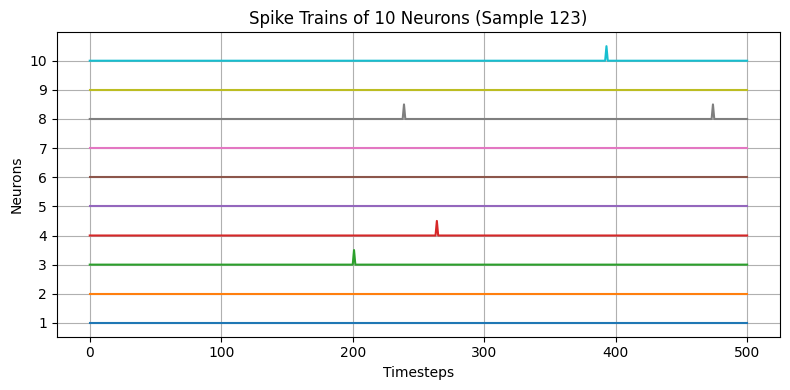

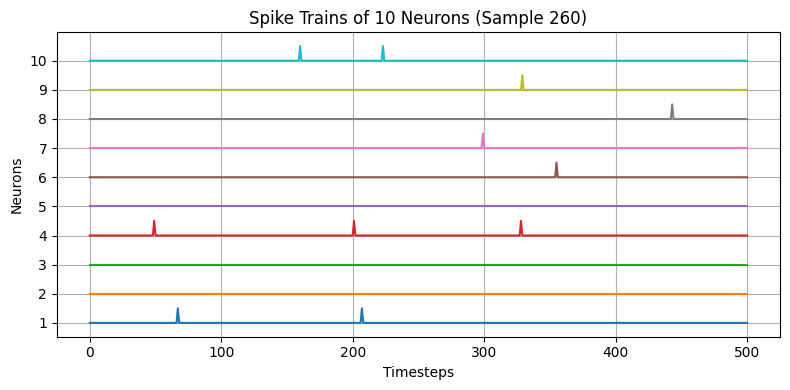

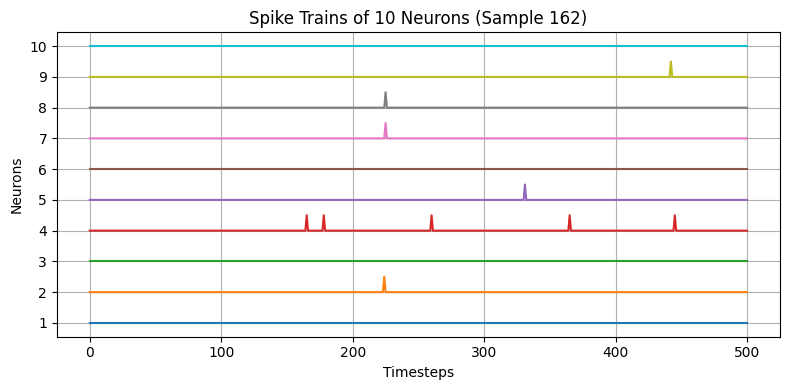

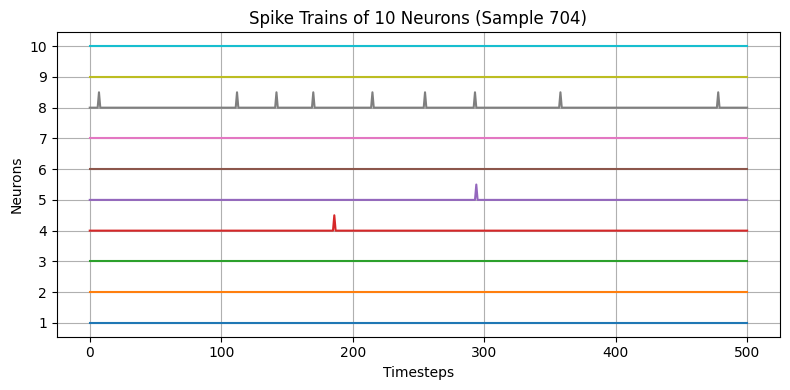

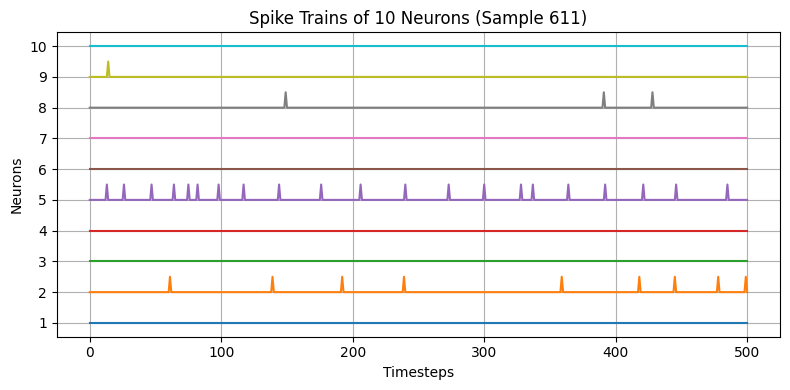

In [53]:
"""
Randomly choosing Spike Trains of 10 Neurons (distributed vertically in the plot) from 5 samples/datasets:
"""


random_samples = np.random.choice(x_data.shape[0], size=5, replace=False) # [0] := 800 number of samples

neurons_to_plot = 10  

for sample_idx in random_samples:
    sample = x_data[sample_idx]
    plt.figure(figsize=(8, 4))
    
    for i in range(neurons_to_plot): 
        spike_trains = plt.plot(sample[i] + i * 2, label=f"Neuron {i}")

    y_ticks = [i * 2 for i in range(neurons_to_plot)] # numerical values of neurons (1 to 10)
    y_labels = [str(i+1) for i in range(neurons_to_plot)]

    
    plt.yticks(y_ticks, y_labels)

    plt.title(f"Spike Trains of {neurons_to_plot} Neurons (Sample {sample_idx})")
    plt.xlabel("Timesteps")
    plt.ylabel("Neurons")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Step 3: Visualizing Firing Rates for Feature Transformation

To transform these random spikes into data suitable for classification, the average firing rate of all neurons across all time steps is calculated and shown in a matrix:

### Step 3.1: Average Firing Rate Per Neuron

In [29]:
firing_rate_per_neuron = np.mean(x_data, axis=2) 
firing_rate_per_neuron

array([[0.        , 0.        , 0.        , ..., 0.00199601, 0.00199601,
        0.        ],
       [0.        , 0.00798403, 0.00598802, ..., 0.        , 0.00199601,
        0.00199601],
       [0.        , 0.        , 0.00199601, ..., 0.        , 0.        ,
        0.00199601],
       ...,
       [0.00199601, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00199601, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00199601],
       [0.03393214, 0.        , 0.        , ..., 0.03592814, 0.01796407,
        0.        ]], shape=(800, 1000))

The output shows how the neurons in the first sample were generally more inactive during the time period than the neurons in the other samples, as the first row of the matrix (sample 1 of 800) has values close to and equal to $0.0$. 
While the second sample has some neurons with higher firing rates, such as $0.00798403$ and $0.00598802$, which indicate more frequent firing during the time window, the last sample shows clearly higher activity for certain neurons, such as $0.03592814$ and $0.03393214$.

For clarity, the difference in average firing activity for each of the 1000 neurons in the first sample is plotted against the last:

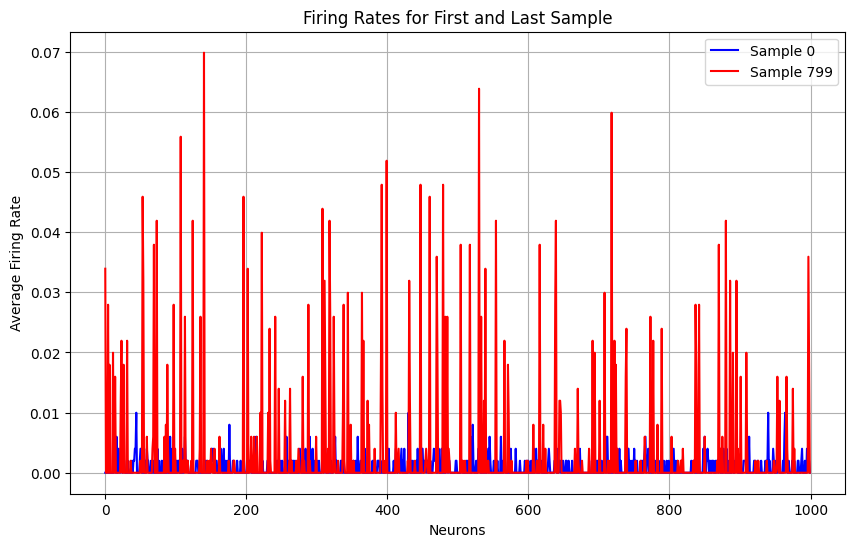

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(firing_rate_per_neuron[0], label="Sample 0", color='blue')
plt.plot(firing_rate_per_neuron[-1], label="Sample 799", color='red')

plt.title("Firing Rates for First and Last Sample")
plt.xlabel("Neurons")
plt.ylabel("Average Firing Rate")
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

The first observation is now confirmed, as the plot shows clear differences in average firing activity, with much higher activity in the last sample than in the first.

The average firing rates of five randomly selected samples - coloured differently - are then plotted to give an overall picture of the differences in neural activity.

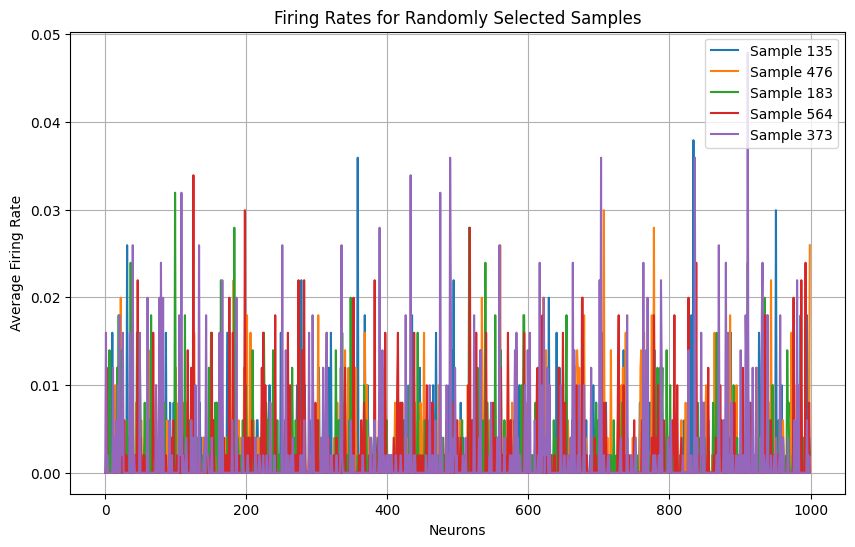

In [31]:
random_samples = np.random.choice(x_data.shape[0], size=5, replace=False)

plt.figure(figsize=(10, 6))
for sample_idx in random_samples:
    plt.plot(firing_rate_per_neuron[sample_idx], label=f"Sample {sample_idx}")
plt.title("Firing Rates for Randomly Selected Samples")
plt.xlabel("Neurons")
plt.ylabel("Average Firing Rate")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [32]:
# for simple classification - logistic regression later on - mean of all neursons = feature per sample

mean_firing_rate = np.mean(firing_rate_per_neuron, axis=1) 


### Step 3.2: Feature Selection Based on Correlation

To remove noise from irrelevant neurons, neurons that are highly correlated with familiarity or unfamiliarity are filtered out and then averaged with $np.corrcoef()$. Since firing synchronisation is related to cognitive processes, we get a subset consisting only of these neurons.

In [33]:
correlation_with_target = np.array([
    np.corrcoef(firing_rate_per_neuron[:, i], y_data)[0, 1]
    for i in range(firing_rate_per_neuron.shape[1])
])
high_correlation_neurons = correlation_with_target > 0.1

print("Max Correlation:", np.max(correlation_with_target))
print("Number of neurons with correlation > 0.1:", np.sum(high_correlation_neurons))

x_high_corr = x_data[:, high_correlation_neurons, :]
firing_rate_per_neuron_high_corr = np.mean(x_high_corr, axis=2)

Max Correlation: 0.18070305029323383
Number of neurons with correlation > 0.1: 163


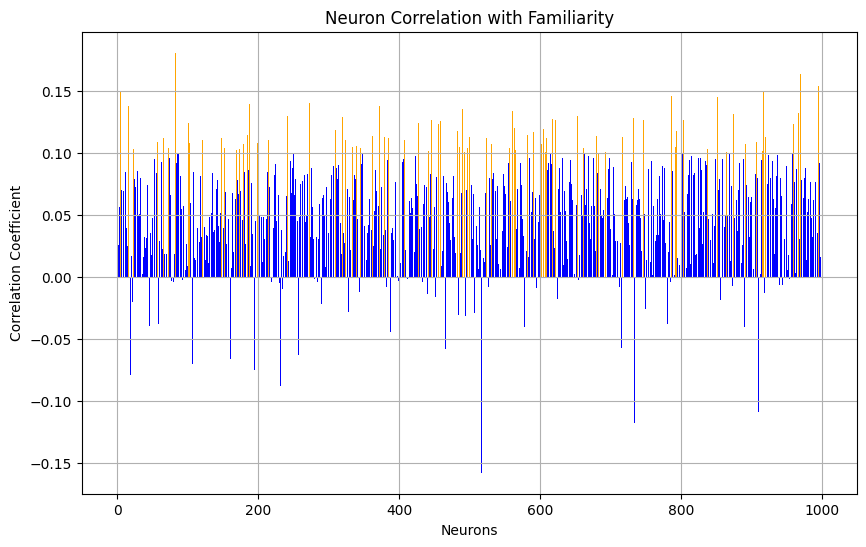

In [34]:
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(correlation_with_target)), correlation_with_target, color='blue')
plt.bar(np.arange(len(correlation_with_target))[high_correlation_neurons], 
        correlation_with_target[high_correlation_neurons], color='orange')
plt.title('Neuron Correlation with Familiarity')
plt.xlabel('Neurons')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()



After calculating the correlation of the average firing rate of each neuron with the target value (familiarity/unfamiliarity), the $\textit{highly correlated neurons}$ (threshold above $0.1$) are filtered out and plotted in orange bars. Because these highly synchronized neurons ($163$) are more likely to be involved in representing the same memory or stimulus, this is useful for extracting meaningful features that help classify whether a stimulus is familiar or not.

The negative values depict that if the firing rate of those neurons increases, the familiarity decreases, whereas the positive values indicate their firing activity is positively related to familiarity. 

The 163 neurons that are highly correlated with the target value (familiarity) - depicted in orange - are key for feature extraction, as their firing rates are strongly linked to whether a stimulus is familiar. These neurons are synchronized in a way that makes them more informative for classification, which is why they are selected for further analysis.

### Step 3.3: Measuring firing synchrony

To better understand the neural activity in the data, the following code calculates the firing synchrony for each sample. The graph plots the already calculated average firing rate against the synchrony in each coloured label, showing only the highly correlated neurons.

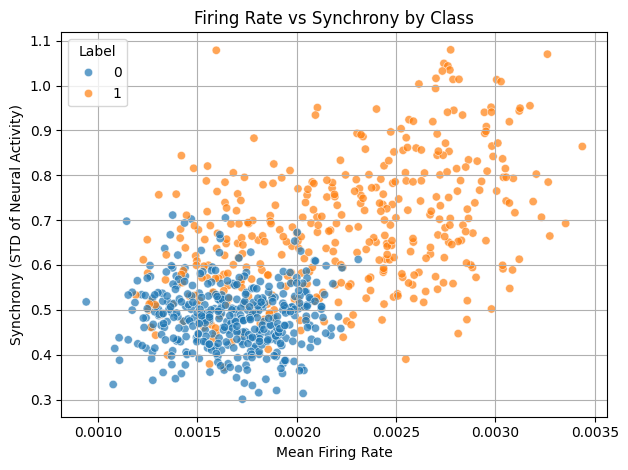

In [35]:
def firing_synchrony(sample_data):
    neural_activity = sample_data.sum(axis=0)
    return np.std(neural_activity)

high_correlation_x_data = x_data[:, high_correlation_neurons, :]
synchrony_features = np.array([firing_synchrony(high_correlation_x_data[i]) for i in range(high_correlation_x_data.shape[0])])  

import pandas as pd
import seaborn as sns

df = pd.DataFrame({
    "MeanFiringRate": mean_firing_rate,   
    "Synchrony": synchrony_features,      
    "Label": y_data                     
})

sns.scatterplot(data=df, x="MeanFiringRate", y="Synchrony", hue="Label", alpha=0.7)
plt.title("Firing Rate vs Synchrony by Class")
plt.xlabel("Mean Firing Rate")
plt.ylabel("Synchrony (STD of Neural Activity)")
plt.grid(True)
plt.tight_layout()
plt.show()


Using only the highly correlated neurons ensures that later classification methods will focus on neurons that are strongly associated with familiarity detection, which we will focus on for the binary classifier, allowing for a more interpretable result as the relationship between firing rate, synchrony, and class label is more likely to show meaningful patterns.

The scatter plot already appears to be divided into two clusters, the one on the left with lower mean firing rates and also relatively low synchrony (highest around 0.7), indicating that the neurons are less synchronised when responding to unfamiliar stimuli, and the one on the right with higher mean firing rates and also more synchronized when firing in response to the familiar stimuli.

### Step 3.4: Fourier Transformation

Frequency features are extracted to provide information about the time-frequency domain of neural activity. Again, the focus is on the highly correlated neurons to reveal clear distinctions between the frequency spectra of familiar and unfamiliar stimuli, as these are the neurons that contribute most to familiarity discrimination. 


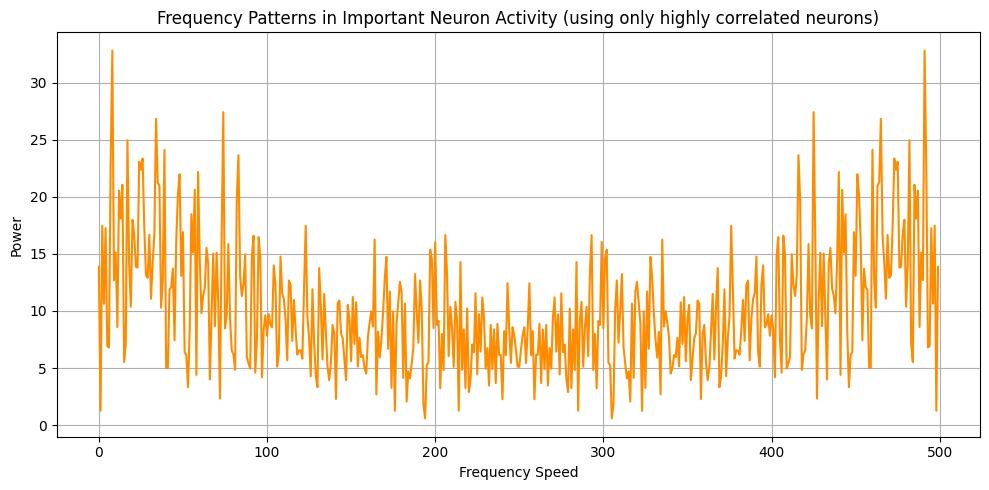

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

def compute_fft_features_correlated(sample_correlated_neurons):
    pop_activity_correlated = sample_correlated_neurons.sum(axis=0)
    fft_result_correlated = fft(pop_activity_correlated)
    power_spectrum_correlated = np.abs(fft_result_correlated)
    return power_spectrum_correlated[1:]  # exclude 0 Hz - baseline (overall average level I am not interested in - only oscillations)

try:
    fft_patterns = compute_fft_features_correlated(high_correlation_x_data[0])
    plt.figure(figsize=(10, 5))
    plt.plot(fft_patterns, color='darkorange')
    plt.title("Frequency Patterns in Important Neuron Activity (using only highly correlated neurons)")
    plt.xlabel("Frequency Speed")
    plt.ylabel("Power")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
except NameError:
    print("Error: 'high_correlation_x_data' not found.")

Finally, to prepare the data for classification, a Fourier transform spectral analysis was used on the summed activity of the key neurons (the highly correlated ones), which is our focus. This plot reveals how much regular, oscillating (periodic) activity was present at different frequencies in the signal.

The average firing rate (see [Step 3.1: Average Firing Rate Per Neuron](#step-31-calculate-average-firing-rate)) represents the neuron's overall activity. Here, the Fourier transform provides information about both the intensity and its periodic nature, specifically how regularly it oscillates.

In the graph, the x-axis represents the different frequency components, from low (slow oscillations in neural activity) to high (rapid fluctuations). The y-axis shows the corresponding power at each frequency – essentially, how strong the periodic signal is at that speed.

Notably, there are some peaks at both ends, indicating extreme activity. Specifically, high peaks at frequencies around 20 and 480 might show how these specific patterns are important for processing familiarity.

As the aim is to extract those frequency-specific features that strongly discriminate between familiar and unfamiliar stimuli, detecting these prominent features is essential. They represent the intensity within the familiarity-relevant neural population and provide temporal structure (timing and pattern of neuronal spikes), which is important for later building the binary classifier.

Now that clear and meaningful features have been extracted - such as how often the neurons fire, how synchronised they are, and the patterns in their timing - it is time to test how well these features distinguish between the two stimulus categories. 

## Step 4: Model Comparison

### Step 4.1: Exploratory Analysis

First, as a baseline, the distributions of mean firing rate of all neurons for familiar and new classes are plotted in a histogram. Alongside the synchrony scatter plot presented earlier, but this time for all neurons, is included as a subplot, to directly compare both feature patterns.

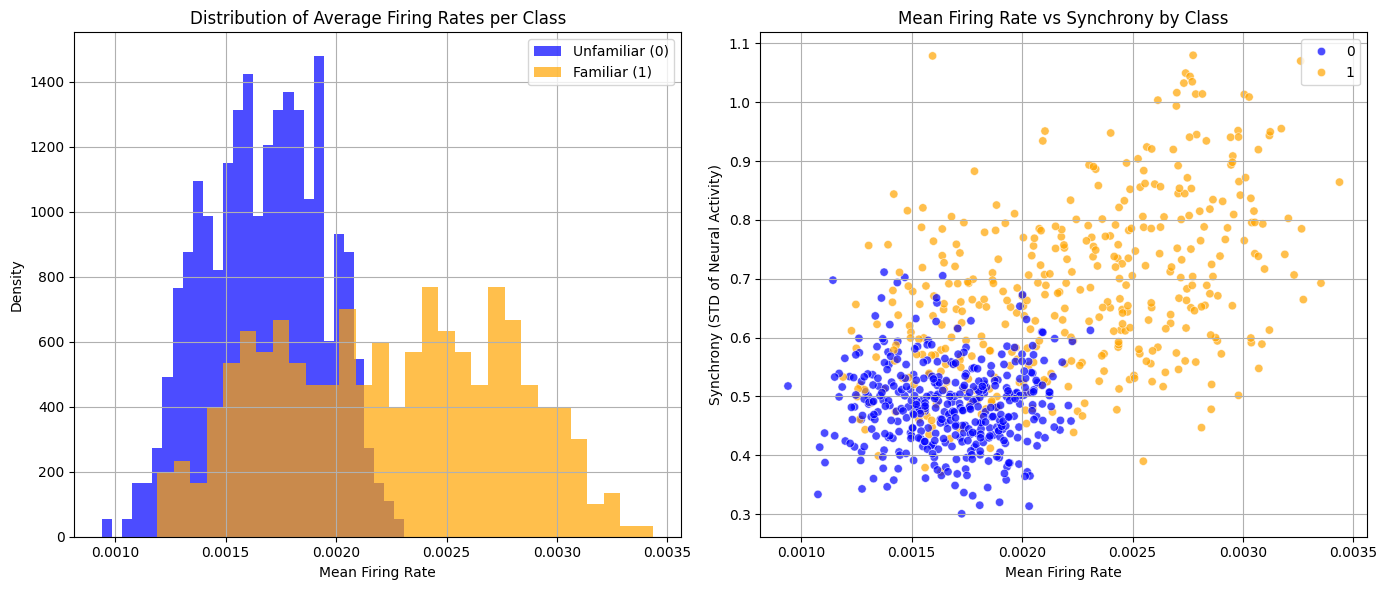

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


familiar_FR = mean_firing_rate[y_data == 1]
unfamiliar_FR = mean_firing_rate[y_data == 0]

axes[0].hist(unfamiliar_FR, bins=30, alpha=0.7, label='Unfamiliar (0)', color='blue', density=True)
axes[0].hist(familiar_FR, bins=30, alpha=0.7, label='Familiar (1)', color='orange', density=True)
axes[0].set_title("Distribution of Average Firing Rates per Class")
axes[0].set_xlabel("Mean Firing Rate")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(True)

sns.scatterplot(
    data=df,
    x="MeanFiringRate",
    y="Synchrony",
    hue="Label",
    palette={0: "blue", 1: "orange"},
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title("Mean Firing Rate vs Synchrony by Class")
axes[1].set_xlabel("Mean Firing Rate")
axes[1].set_ylabel("Synchrony (STD of Neural Activity)")
axes[1].legend()
axes[1].grid(True)

# overlap
plt.tight_layout()
plt.show()

Familiar stimuli lead to higher average firing rates and more synchronized neuron activity, while unfamiliar ones show lower rates and less synchrony. This forms two clear clusters:

#### 1) Unfamiliar: low firing + low synchrony

#### 2) Familiar: high firing + high synchrony

The Fourier analysis from earlier showed strong frequency peaks for familiar stimuli, making frequency a useful feature for classification as well.

Overall, the data show a clear structure that allows the difference between the distributions of different stimuli to be measured.

### Step 4.2: Measuring the difference between distributions of the data for different classes
Since it is important to evaluate whether the extracted features meaningfully separate the two classes, quantitative evidence (calculating KL divergence, Log-Likelihood, and Deviance) of discriminative information must be useful for classification.

#### Step 4.2.1: Kullback-Leibler (KL) information (divergence) ($\textit{cf. Lecture 11, Slides 35-41}$)

The KL divergence is used to quantify how distinguishable the distributions of familiarity and unfamiliarity are mathematically. The measurement calculates how much one probability distribution ($p$) diverges from another ($q$). 


In [38]:
from scipy.stats import gaussian_kde
from scipy.integrate import simpson
import numpy as np

# separating the data
familiar_FR = mean_firing_rate[y_data == 1]
unfamiliar_FR = mean_firing_rate[y_data == 0]

# estimating the distributions using Kernel Density Estimation
x = np.linspace(min(mean_firing_rate), max(mean_firing_rate), 1000)
kde_fam = gaussian_kde(familiar_FR)
kde_unfam = gaussian_kde(unfamiliar_FR)

p = kde_fam(x)
q = kde_unfam(x)

# normalized (to treat as true probability densities)
p /= simpson(p, x)
q /= simpson(q, x)

# calculating  KL divergence: D_KL(p || q)
kl_divergence = np.sum(p * np.log(p / q))

print("KL Divergence (familiar || unfamiliar):", kl_divergence)

KL Divergence (familiar || unfamiliar): 4079908.305398836


The KL divergence value of $4,079,908.31$ indicates that there is a significant difference between the firing rate distributions for familiar and unfamiliar stimuli, as the value is really large. This means that the firing rate is a very useful feature to distinguish between the two categories, and this distinction could be used to build a classifier, as the classes are highly distinguishable.

#### Step 4.2.2: Log-Likelihood Comparison and Deviance (Model Fit Quality ($\textit{cf. Lecture 11, Slides 12-22}$)

For further analysis, log-likelihoods are calculated using the means and standard deviations of both classes, which represent how well the models fit the data for each class.

In [39]:
from scipy.stats import norm

# fit gaussians
fam = mean_firing_rate[y_data == 1]
unfam = mean_firing_rate[y_data == 0]
ll_fam = np.sum(norm.logpdf(fam, np.mean(fam), np.std(fam)))
ll_unfam = np.sum(norm.logpdf(unfam, np.mean(unfam), np.std(unfam)))

print(f"Log-likelihood (familiar): {ll_fam:.2f}")
print(f"Log-likelihood (unfamiliar): {ll_unfam:.2f}")

deviance = 2 * (ll_fam - ll_unfam)
print(f"Deviance between familiar and unfamiliar class models: {deviance:.2f}")

Log-likelihood (familiar): 2454.53
Log-likelihood (unfamiliar): 2729.23
Deviance between familiar and unfamiliar class models: -549.39


Since the log-likelihood for unfamiliar stimuli is higher ($2729.23$) than for familiar stimuli ($2454.53$), it can be concluded that the model fits the familiar class data worse than the unfamiliar class data. This could mean that the neural response to unfamiliar stimuli is more variable or less predictable, and therefore the model fits it better.
The Deviance was also calculated and gives a value of $-549.39$, which is a negative value indicating that the familiar class model performs worse than the unfamiliar class model. This is consistent with the previous finding of higher log-likelihood.

#### Step 4.2.2: AIC (Akaike Information Criterion) ($\textit{cf. Lecture 11, Slides 28-34}$)




In [40]:
k = 2 # mean and std for gauss := number of parameters used

aic_fam = 2 * k - 2 * ll_fam
aic_unfam = 2 * k - 2 * ll_unfam

print(f"AIC for Familiar Class: {aic_fam:.2f}")
print(f"AIC for Unfamiliar Class: {aic_unfam:.2f}")


AIC for Familiar Class: -4905.06
AIC for Unfamiliar Class: -5454.45


In a final metric, the AIC was calculated, confirming that the model for the unfamiliar class is more efficient, a better fit with fewer parameters, compared to the model for the familiar class, since it has a higher AIC information than the unfamiliar class.

## Step 5: Training and Evaluating a Binary Classifier

During this chapter, the performance of the model is evaluated using accuracy, F1 score and a classification report.

Given the linear nature of the data, logistic regression is a good place to start as a simple model. It is interpretable, and I expect it to work well as linear relationships exist between the features and the labels. 

### Step 5.1: Baseline Model - Logistic Regression on Mean Firing Rate

===== 5.1 Logistic Regression (FR only) =====
Accuracy:  0.7167
F1-score:  0.7018
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.77      0.73       120
           1       0.74      0.67      0.70       120

    accuracy                           0.72       240
   macro avg       0.72      0.72      0.72       240
weighted avg       0.72      0.72      0.72       240



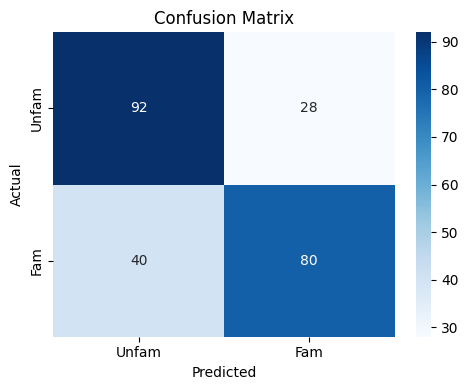

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

def preprocess_data(X):
    """
    Normalizes X to zero mean and unit variance.
    """
    scaler = StandardScaler()
    return scaler.fit_transform(X)

def train_logistic_regression(x_train, y_train, max_iter=10000):
    """
    Trains a Logistic Regression model using training data.
    """
    logreg = LogisticRegression(max_iter=max_iter)
    logreg.fit(x_train, y_train)
    return logreg

def evaluate_model(clf, X_test, y_test):
    """
    Evaluates the trained model and prints:
     - Accuracy, F1-score, ROC-AUC
     - classification report
     - confusion matrix plot
    """
    y_pred  = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    print(f"Accuracy:  {acc:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Unfam','Fam'],
                yticklabels=['Unfam','Fam'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# ——— 5.1: Model Performance (FR only) ———

print("===== 5.1 Logistic Regression (FR only) =====")

X1 = mean_firing_rate.reshape(-1, 1)  # (n_samples, 1)
y  = y_data

X1n = preprocess_data(X1)

X1_tr, X1_te, y1_tr, y1_te = train_test_split(
    X1n, y, test_size=0.3, stratify=y, random_state=42
)

clf1 = train_logistic_regression(X1_tr, y1_tr)
evaluate_model(clf1, X1_te, y1_te)


Using only the mean firing rate, the model correctly classifies ~72% of stimuli. It favors recalling unfamiliar trials (recall ≈ 0.77) slightly more than familiar ones (recall ≈ 0.67), reflecting that firing rate alone captures much - but not all - of the difference between “familiar” and “unfamiliar.” Next, the synchrony feature will be added and compared how much that boosts performance.

### Step 5.2: Enhanced Model - Adding Synchrony to Logistic Regression

===== 5.2 Logistic Regression (FR + Synchrony) =====
Accuracy:  0.8500
F1-score:  0.8407
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86       120
           1       0.90      0.79      0.84       120

    accuracy                           0.85       240
   macro avg       0.85      0.85      0.85       240
weighted avg       0.85      0.85      0.85       240



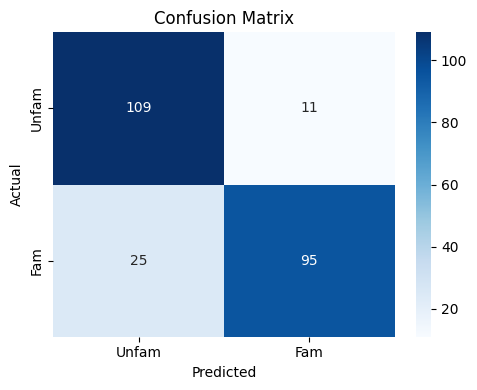

In [42]:
# ——— 5.2: Model Performance (FR + Synchrony) ———

print("===== 5.2 Logistic Regression (FR + Synchrony) =====")

# a) prepare data
X2 = np.column_stack([mean_firing_rate, synchrony_features])  # (n_samples, 2)

# b) normalize
X2n = preprocess_data(X2)

# c) train/test split
X2_tr, X2_te, y2_tr, y2_te = train_test_split(
    X2n, y, test_size=0.3, stratify=y, random_state=42
)

# d) train & evaluate
clf2 = train_logistic_regression(X2_tr, y2_tr)
evaluate_model(clf2, X2_te, y2_te)

Having the additional information of how neurons fire together (synchrony), rather than just how fast they fire (firing rate), improved the model’s performance significantly. The accuracy increased from $71.7\%$ to $85.0\%$, meaning that 85 out of 100 stimuli were correctly classified. In addition, the F1-score rose from $0.70$ to $0.84$, showing a much better balance between precision (how many predicted "familiars" were actually familiar) and recall (how many actual familiars are successfully caught).

This improvement is also visible in the confusion matrix: the number of misclassified familiar and unfamiliar trials decreased, and the model made fewer mistakes in both directions. It became more reliable at telling the two classes apart.

### Step 5.3: Visualizing the Decision Boundary in FR–Synchrony Space (trained with LogReg)

===== 5.3 Decision Boundary (FR + Synchrony) =====


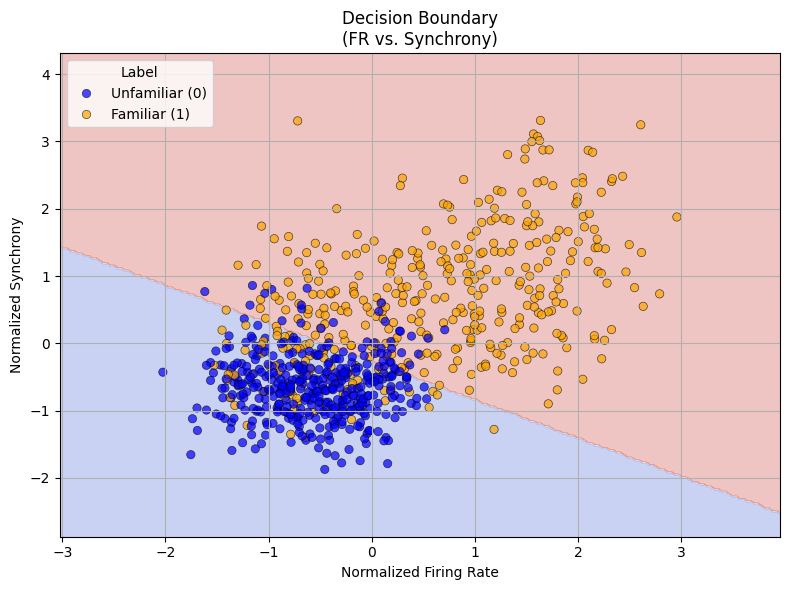

In [43]:
# ——— 5.3: Decision Boundary (FR + Synchrony) ———

print("===== 5.3 Decision Boundary (FR + Synchrony) =====")

x_min, x_max = X2n[:,0].min() - 1, X2n[:,0].max() + 1
y_min, y_max = X2n[:,1].min() - 1, X2n[:,1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

# predicting class for each point  on grid
Z = clf2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
scatter = sns.scatterplot(x=X2n[:,0], y=X2n[:,1], hue=y,
                palette={0:'blue',1:'orange'},
                edgecolor='k', alpha=0.7)
plt.title("Decision Boundary\n(FR vs. Synchrony)")
plt.xlabel("Normalized Firing Rate")
plt.ylabel("Normalized Synchrony")
handles, _ = scatter.get_legend_handles_labels()
plt.legend(handles=handles, title="Label", labels=["Unfamiliar (0)", "Familiar (1)"])
plt.grid(True)
plt.tight_layout()
plt.show()

The model has learned to separate areas (with a so-called "decision boundary") of high and low synchrony, with higher firing rates in the 'familiar' region. Data points closer to the left (blue region) represent 'unfamiliar' stimuli, and data points closer to the right (orange region) represent 'familiar' stimuli. 

Because the dataset has equal numbers of familiar and unfamiliar samples, the boundary sits roughly in the middle. This means that the logistic regression model tries to separate the two classes in a fair way by treating them equally. As the decision boundary is a straight line, it shows that the model is making decisions based on simple patterns in the data. A few blue dots in the red region and orange dots in the blue region are noticed here, but those are small errors where the two classes overlap in feature space.

Basically, the model has learned a simple rule: If a sample has a combination of low firing rate and low synchrony, call it unfamiliar; if it has high firing rate and/or high synchrony, call it familiar. 

## Step 6: Comparing Multiple Models

In this chapter, several models are compared to determine how different feature sets, neural coding methods, and classification algorithms affect the model's ability to discriminate between familiar and unfamiliar stimuli.

By systematically changing the input features and the learning algorithm, the influence of each choice on classification performance and interpretability is investigated. 

### Step 6.1: Feature Set Comparison - Adding FFT-band Power

First, the previous FR - Synchrony feature set is extended using the FT from Step 3.4:

In [44]:
"""
For using FFt-band power as a third feature for classification, the FFt for all 800 samples is now 
computed, using the "compute_fft_features_correlated" function from Step 3.4
"""

fft_spectra = np.array([
    compute_fft_features_correlated(high_correlation_x_data[i])
    for i in range(high_correlation_x_data.shape[0])
])
fft_band = fft_spectra[:, :10].mean(axis=1)  # shape: (800,)


# ************* Final feature set ****************************************
X3 = np.column_stack([mean_firing_rate, synchrony_features, fft_band])

feature_sets = {
    "FR + Sync + FFT‐band":  np.column_stack([mean_firing_rate,
                                              synchrony_features,
                                              fft_band])  # make sure fft_band is length‐800
}

### Step 6.2: Classifier Comparison - logReg and SVM-RBF

In the following, two classification algorithms (logReg and SVM) are tested on the same feature set. I have chosen to use the SVM classifier because, unlike logistic regression, it remains a non-linear model capable of capturing more complex decision boundaries, and the graph looked as if there might also be roundish clusters, looking at the density of points in both regions.


--- LogReg on FR + Sync + FFT‐band ---
Accuracy:  0.8500
F1-score:  0.8407
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86       120
           1       0.90      0.79      0.84       120

    accuracy                           0.85       240
   macro avg       0.85      0.85      0.85       240
weighted avg       0.85      0.85      0.85       240



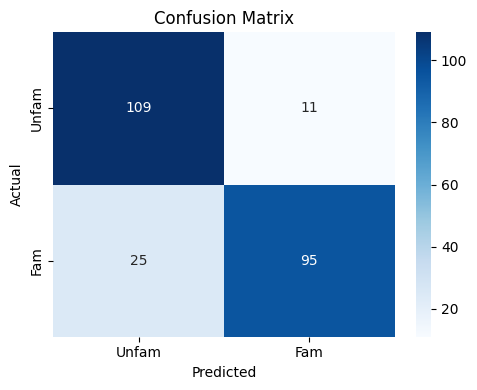


--- SVM-RBF on FR + Sync + FFT‐band ---
Accuracy:  0.8417
F1-score:  0.8224
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.95      0.86       120
           1       0.94      0.73      0.82       120

    accuracy                           0.84       240
   macro avg       0.86      0.84      0.84       240
weighted avg       0.86      0.84      0.84       240



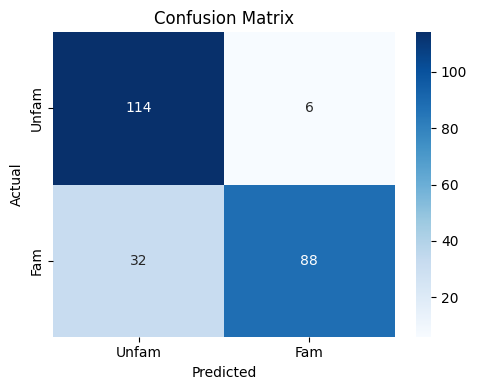

In [45]:
from sklearn.svm import SVC # new classifier imported from sklearn

classifiers = {
    "LogReg": LogisticRegression(max_iter=1000),
    "SVM-RBF": SVC(kernel="rbf", probability=True)
}

"""
Training and Evaluation Loop
"""
for feat_name, X in feature_sets.items():
    Xn = preprocess_data(X)   # normalize
    for clf_name, clf in classifiers.items():
        Xtr, Xte, ytr, yte = train_test_split(
            Xn, y_data, test_size=0.3, stratify=y_data, random_state=42
        )
        model = clf.fit(Xtr, ytr) # train
        print(f"\n--- {clf_name} on {feat_name} ---")
        evaluate_model(model, Xte, yte)


While logReg is a good simple model that performs well with both classes (precisions of $prec_0=0.81$ and $prec_1=0.90$), the SVM-RBF classifier performs similarly in terms of overall accuracy ($accuracy_{logReg}\approx 0.85$ and $accuracy_{SVM}\approx 0.84$), but struggles more with class 1 (lower recall than logReg). The F1 score of SVM is also slightly lower. Basically, if the focus is on balanced recall - a model that identifies both classes well - LogReg is a simple model and an overall good performer. However, SVM could be a good choice as it caught all class 0 instances with its higher recall for class 0.

### Step 6.3: Visualizing the Decision Boundary in FR–Synchrony Space (trained with SVM-RBF)

To compare decision surfaces, the splitting of the SVM-RBF classifier is visualized. It uses only FR and synchrony first. 

===== 6.3 Decision Boundary (FR + Synchrony) - SVM trained =====


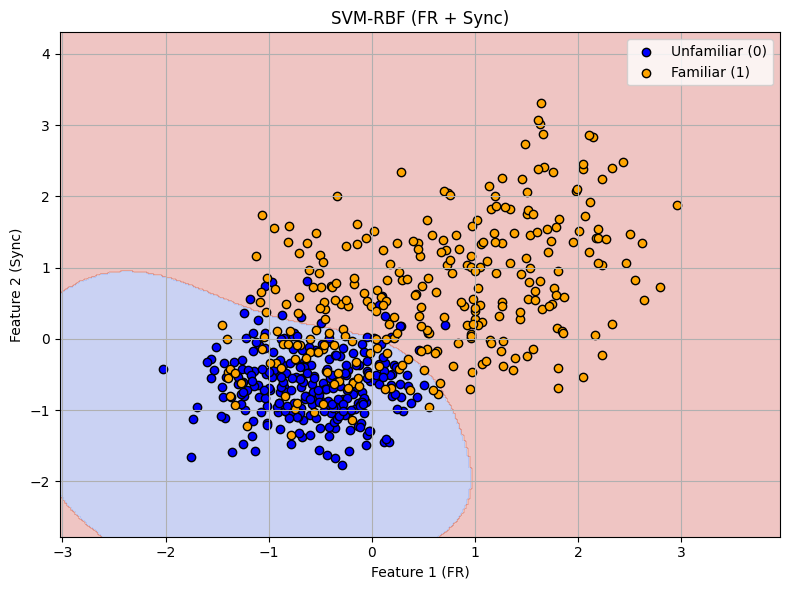

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# ——— 6.3: Decision Boundary (FR + Synchrony) SVM trained ———

print("===== 6.3 Decision Boundary (FR + Synchrony) - SVM trained =====")

# ********* normalize data ****************************
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X3)

X_scaled_2D = X_scaled[:, :2]  # using only FR and Sync

# ********* split into train/test *********************
X_train, X_test, y_train, y_test = train_test_split(X_scaled_2D, y_data, test_size=0.3, random_state=42)

# ******* training SVM-RBF on 2 features **************
svm_rbf = SVC(kernel='rbf', probability=True)
svm_rbf.fit(X_train, y_train)

def plot_decision_boundary(clf, X, y, ax, title):
    h = .02  # step size for the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    colors = np.array(['blue', 'orange'])[y]
    ax.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', label='Unfamiliar (0)', edgecolors='k')
    ax.scatter(X[y == 1, 0], X[y == 1, 1], c='orange', label='Familiar (1)', edgecolors='k')
    ax.set_title(title)
    ax.set_xlabel('Feature 1 (FR)')
    ax.set_ylabel('Feature 2 (Sync)')
    ax.legend()
    ax.grid(True)

fig, ax = plt.subplots(figsize=(8, 6))
plot_decision_boundary(svm_rbf, X_train, y_train, ax, "SVM-RBF (FR + Sync)")
plt.tight_layout()
plt.show()

The decision surface is non-linear and captures the curved separation between classes, especially near the feature overlaps.

### Step 6.4: Including the FFT Power Feature in the Plot

To interpret the contribution of the FF band power, it is now displayed as a color gradient on the FR synchrony space:

===== 6.4 Decision Boundary (FR + Synchrony + FFT) - SVM trained =====


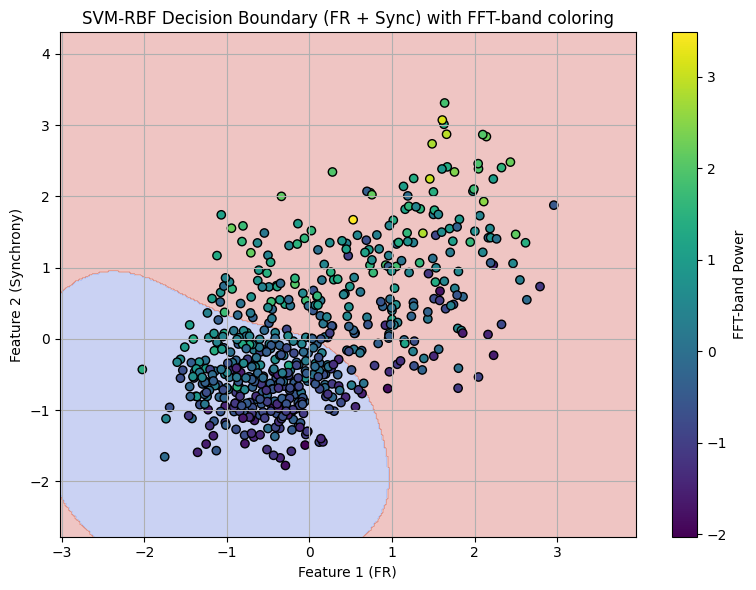

In [47]:
# ——— 6.4: Decision Boundary (FR + Synchrony + FFT) SVM trained ———

print("===== 6.4 Decision Boundary (FR + Synchrony + FFT) - SVM trained =====")

# ********* normalize data ****************************
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X3)

X_scaled_2D = X_scaled[:, :2]  # FR and Sync
fft_band_feature = X_scaled[:, 2]  # safe FFT-band

# ********* split & train *****************************
X_train, X_test, y_train, y_test, fft_train, fft_test = train_test_split(
    X_scaled_2D, y_data, fft_band_feature, test_size=0.3, random_state=42
)

# ******* training SVM-RBF on 2 features **************
svm_rbf = SVC(kernel='rbf', probability=True)
svm_rbf.fit(X_train, y_train)

def plot_decision_boundary_with_fft(clf, X, y, fft_feature, ax, title):
    h = .02  # mesh step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    
    # data points, color-coded by FFT feature
    scatter = ax.scatter(X[:, 0], X[:, 1], c=fft_feature, cmap="viridis", edgecolors='k')
    plt.colorbar(scatter, ax=ax, label="FFT-band Power")
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1 (FR)')
    ax.set_ylabel('Feature 2 (Synchrony)')
    ax.grid(True)


fig, ax = plt.subplots(figsize=(8, 6))
plot_decision_boundary_with_fft(svm_rbf, X_train, y_train, fft_train, ax, "SVM-RBF Decision Boundary (FR + Sync) with FFT-band coloring")
plt.tight_layout()
plt.show()


The SVM model uses firing rate and synchrony to split the samples into familiar and unfamiliar, and the Fourier/FFT feature (plotted as color) shows that higher oscillation power is more associated with familiar stimuli.
Its decision boundary tries to separate the two classes as cleanly as possible, but obviously, there is some overlap, because brain data is noisy and classes are not perfectly separable.

Nevertheless, the separation is visually reasonable, particularly in the left regions of the plot where data points are more densely clustered.

## Step 7: Conclusion

This study involved analyzing spike train data from 800 experiments, each recording the firing activity of multiple neurons in response to a stimulus. The objective was to develop a binary classifier capable of determining whether a stimulus was familiar or unfamiliar based on neural activity. 

Several features were extracted to transform the raw spike data into a format suitable for classification, including mean firing rate, neuronal synchrony, and frequency-domain information (through the Fourier transform). These features were used to train and evaluate 2 classifiers: logistic regression and a support vector machine (SVM).

In summary, the (mean) firing rate alone gave a good overview of the differences in firing activity in the samples by displaying them in a histogram. However, its classification accuracy stopped at around $\71\%$, indicating limited discriminative power on its own.
Adding synchrony significantly improved the model's performance. It captured internal interactions that firing rate alone could not.  With this 2-feature combination, accuracy increased to $85\%$, demonstrating that both individual activity levels and the dynamics in between are important for identifying familiarity.

Including the FFT band power (averaged over the first 10 frequency bins) added a temporal frequency component to the model. Although this feature did not further improve the performance of the model with LogReg (accuracy stayed at $85\%$), it provided an important insight into the oscillatory nature of familiar stimuli. When visualized, higher FFTs were more common in familiar patterns, indicating that these stimuli may induce more structured firing patterns.
Finally, when the non-linear classifier SVM-RBF was used, the FFT band feature contributed modest performance gains and showed potential in scenarios where temporal structure plays a greater role.

## Step 8: Outlook

While not every feature made the model more accurate when using a simple (linear) method, each one added useful information. Together, a better understanding of the data is achieved, which makes the model more reliable.

For future improvements, a good approach would be to look at more parts of the frequency range (not just the first 10 values) to find more useful patterns. It might also be helpful to use methods such as PCA to reduce the number of FFT features rather than just averaging them, and to try more powerful models such as neural networks that can find more complex patterns in the data.